In [2]:

R_FOIL = 0.015
L_DRIFT = 0.25
R_APERTURE = 0.015




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from cross_sections import (
    gen_cross_section_compton,
    gen_cross_section_pairproduction,
    load_pairproduction_cross_section,
)
from acceptance import SRXMData, foil_trace, Foil, aperture
from physical_constants import mol, MeV,millimeter, centimeter


def prepare_monte_carlo(
    x_depth_mm: float,
    Z: int,
    x_density: float,
    x_atomic_weight: float,
    material_name: str,
):
    x_number_density = x_density * 1e6 / x_atomic_weight * mol  # [/m^3]

    with open(f"./_data/estar_{material_name}.txt", "r", encoding="utf8") as srem:
        x_srem = np.array(
            [[float(y) for y in x.split(" ")[:2]] for x in srem.readlines()[9:]]
        )
        x_srem[:, 0] *= MeV  #  MeV  ->  J
        x_srem[:, 1] *= x_density * MeV / centimeter  #  MeV cm^2 / g  ->  J / m
        # x_srem[:, 1] *= 0  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        x_srem: SRXMData = x_srem[:, 0], x_srem[:, 1]

    x_crosssection_compton = gen_cross_section_compton(
        x_number_density * Z,
        np.linspace(2, 20, 50) * MeV,
        np.linspace(0.0, np.pi, 1000),
    )
    x_crosssection_pairproduction = gen_cross_section_pairproduction(
        Z,
        x_number_density,
        load_pairproduction_cross_section("./_data/pairprod_xsctn_medium.npz"),
    )
    x_foil: Foil = x_srem, [
        x_crosssection_compton,
        x_crosssection_pairproduction,
    ]

    def eval_it(
        gamma_energy: float, 
        N: int,        
        do_plots=False,
        do_logs=False,
    ):
        elec_angle, elec_energy, ids = foil_trace(
            n_rays_incident=N,
            n_srxm_steps=100,
            phot_energy_in=gamma_energy,
            foil_properties=x_foil,
            foil_depth=x_depth_mm * millimeter,
        )

        output_data = aperture(
            (elec_angle, elec_energy, ids), R_FOIL, R_APERTURE, L_DRIFT
        )
        t, p, x, y, en, i = output_data
        if do_logs:
            print(f"------ {material_name} {x_depth_mm}mm, gamma energy: {gamma_energy/MeV} MeV ------")
            print(f"pre-aperture efficiency: {elec_energy.size / N}")

            foil_area = 3.14159 * (R_FOIL / 1e-2) ** 2
            gamma_per_cm2_MW = 1.5e3

            print(f"post-aperture efficiency: {en.size / N}  [1/{N / en.size }]")
            print(f"electrons per megawatt: {(en.size / N) * gamma_per_cm2_MW * foil_area}")
            print(f"electrons @140MW: {(en.size / N) * gamma_per_cm2_MW * foil_area * 140}")
            print(
                f"post-aperture efficiency [compton only]: {en[i==0].size / N}  [1/{N / en[i==0].size }]"
            )
            print(
                f"electrons per megawatt [compton only]: {(en[i==0].size / N) * gamma_per_cm2_MW * foil_area}"
            )
            print(
                f"electrons @140MW [compton only]: {(en[i==0].size / N) * gamma_per_cm2_MW * foil_area * 140}"
            )

            print(
                f"[{np.min(en[i==0])/MeV} : {np.max(en[i==0])/MeV}] [{np.min(en[i==1])/MeV} : {np.max(en[i==1])/MeV}]"
            )

        if do_plots:
            plt.hist2d(elec_angle, elec_energy / MeV, bins=150)
            plt.title(f"{material_name[0].upper()}{material_name[1:]} {x_depth_mm}mm")
            plt.xlabel("electron angle /rad")
            plt.ylabel("electron energy /MeV")
            plt.show()
            # plt.hist([en[i == 0] / MeV, en[i == 1] / MeV], bins=250, stacked=True)
            plt.hist([en[i == 0] / MeV, en[i == 1] / MeV], bins=int(16 / 0.150), stacked=True)
            plt.title(
                f"post-aperture electron energy\n[{material_name[0].upper()}{material_name[1:]} {x_depth_mm}mm; foil r={R_FOIL/0.01}cm, drift {L_DRIFT/0.01}cm, aperture r={R_APERTURE}]"
            )
            plt.legend(["compton", "pair production"])
            plt.xlabel("electron energy /MeV")
            plt.ylabel("counts")
            plt.show()

        return output_data
    return eval_it


x_depth_mm = 2.5e-1
# N_BY_Z = 1_000_000_000
N_BY_Z = 1_000_000


# Z = 3
# do_monte_carlo = prepare_monte_carlo(
#     Z = Z,
#     x_density = 0.5334,  # [g/cm^3]
#     x_atomic_weight = 6.94,  # [amu | g/mol]
#     material_name = "li",
#     x_depth_mm=x_depth_mm,
# )

# Z = 4
# do_monte_carlo = prepare_monte_carlo(
#     Z = Z,
#     x_density = 1.845,  # [g/cm^3]
#     x_atomic_weight = 9.0122,  # [amu | g/mol]
#     material_name = "be",
#     x_depth_mm=x_depth_mm,
# )

# Z = 6
# do_monte_carlo = prepare_monte_carlo(
#     Z = Z,
#     x_density = 2.18,  # [g/cm^3]
#     x_atomic_weight = 12.011,  # [amu | g/mol]
#     material_name = "graphite",
#     x_depth_mm=x_depth_mm,
# )

Z = 16
do_monte_carlo = prepare_monte_carlo(
    Z = Z,
    x_density = 2.329085,  # [g/cm^3]
    x_atomic_weight = 28.085,  # [amu | g/mol]
    material_name = "si",
    x_depth_mm=x_depth_mm,
)

# Z = 26
# do_monte_carlo = prepare_monte_carlo(
#     Z = Z,
#     x_density = 7.874,  # [g/cm^3]
#     x_atomic_weight = 55.845,  # [amu | g/mol]
#     material_name = "fe",
#     x_depth_mm=x_depth_mm,
# )

# Z = 79
# do_monte_carlo = prepare_monte_carlo(
#     Z = Z,
#     x_density = 19.283,  # [g/cm^3]
#     x_atomic_weight = 196.966570,  # [amu | g/mol]
#     material_name = "au",
#     x_depth_mm=x_depth_mm,
# )



/home/skylol/Desktop/school/U0/code/mer_prototype/util.py:88: RuntimeWarning: invalid value encountered in divide
  return np.transpose(x / x[-1], axes=axes)


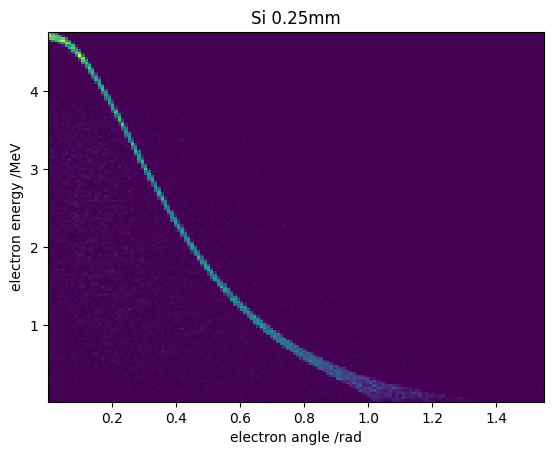

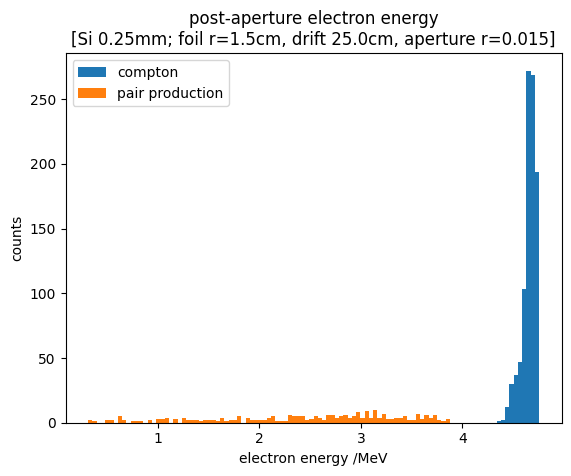

(array([0.00677165, 0.00466195, 0.01057342, ..., 0.05061616, 0.03007952,
        0.00899005]),
 array([5.33286185, 0.57703197, 5.8637685 , ..., 4.80294051, 1.97456776,
        5.05824417]),
 array([ 0.00924188, -0.01379833,  0.00444319, ..., -0.00059425,
        -0.01041086,  0.004073  ]),
 array([ 0.00520411, -0.00128476,  0.00538975, ..., -0.00281063,
        -0.00096941,  0.01134543]),
 array([7.46794601e-13, 7.59458656e-13, 7.61468938e-13, ...,
        4.90135719e-13, 4.18465849e-13, 2.10817064e-13]),
 array([0., 0., 0., ..., 1., 1., 1.]))

In [4]:
do_monte_carlo(5*MeV,10_000_000,do_plots=True)

In [5]:
from mrs_ion_optics import gen_charictaristic_rays, MRSIonOptics
import mrs_ion_optics as K
from IPython.core.display import SVG, display_svg
import numpy as np


sess = (
    MRSIonOptics()
    .disable_fit()
    .config_order(1)
    .config_vis_lab_coordinates(False)
    .config_outputs(
        [
            "ME(1,1)",  # magnification (dispersive direction)
            "ME(1,2)",  # focus (dispersive direction)
            "ME(1,6)",  # dispersion (dispersive direction)
            "ME(3,1)",  # magnification (vertical direction)
            "ME(3,2)",  # focus (vertical direction)
            "(VMAX(RAY(1))-VMIN(RAY(1)))/2",  # image size (dispersive direction)
            "(VMAX(RAY(3))-VMIN(RAY(3)))/2",  # image size (vertical direction)
        ],
        do_beamsize=True,
    )
    .set_parameters(
        {
            K.K_p_bend_radius: 0.55,
            K.K_p_bend_angle: 110.0,
            K.K_p_drift_post_aperture: 0.05,
            K.K_p_drift_pre_bend: 0.1711294047732842,
            K.K_p_drift_post_bend: 0.2014765625,
            K.K_p_drift_pre_hodoscope: 0.228115896571998,
            K.K_p_m5a_length: 0.1,
            K.K_p_m5a_quad: -0.06233481854188321,
            K.K_p_m5a_hex: 0.0,
            K.K_p_m5a_oct: 0.0,
            K.K_p_m5a_dec: 0.0,
            K.K_p_m5a_dodec: 0.0,
            K.K_p_m5b_length: 0.1,
            K.K_p_m5b_quad: 0.115469210096311,
            K.K_p_m5b_hex: 0.0,
            K.K_p_m5b_oct: 0.0,
            K.K_p_m5b_dec: 0.0,
            K.K_p_m5b_dodec: 0.0,
            K.K_p_shape_in_1: 0.2985833653414149,
            K.K_p_shape_in_2: 0.0,
            K.K_p_shape_in_3: 0.0,
            K.K_p_shape_in_4: 0.0,
            K.K_p_shape_in_5: 0.0,
            K.K_p_shape_out_1: 0.176719510472977,
            K.K_p_shape_out_2: 0.0,
            K.K_p_shape_out_3: 0.0,
            K.K_p_shape_out_4: 0.0,
            K.K_p_shape_out_5: 0.0,
            K.K_p_drift_m5a_m5b: 0.1,
            K.K_p_m5c_length: 0.1,
            K.K_p_m5c_quad: -0.01585503500342181,
            K.K_p_m5c_hex: 0.0,
            K.K_p_m5c_oct: 0.0,
            K.K_p_m5c_dec: 0.0,
            K.K_p_m5c_dodec: 0.0,
            K.K_p_drift_m5c_m5d: 0.1,
            K.K_p_m5d_length: 0.1,
            K.K_p_m5d_quad: -0.5,
            K.K_p_m5d_hex: 0.0,
            K.K_p_m5d_oct: 0.0,
            K.K_p_m5d_dec: 0.0,
            K.K_p_m5d_dodec: 0.0,
        }
    )
)

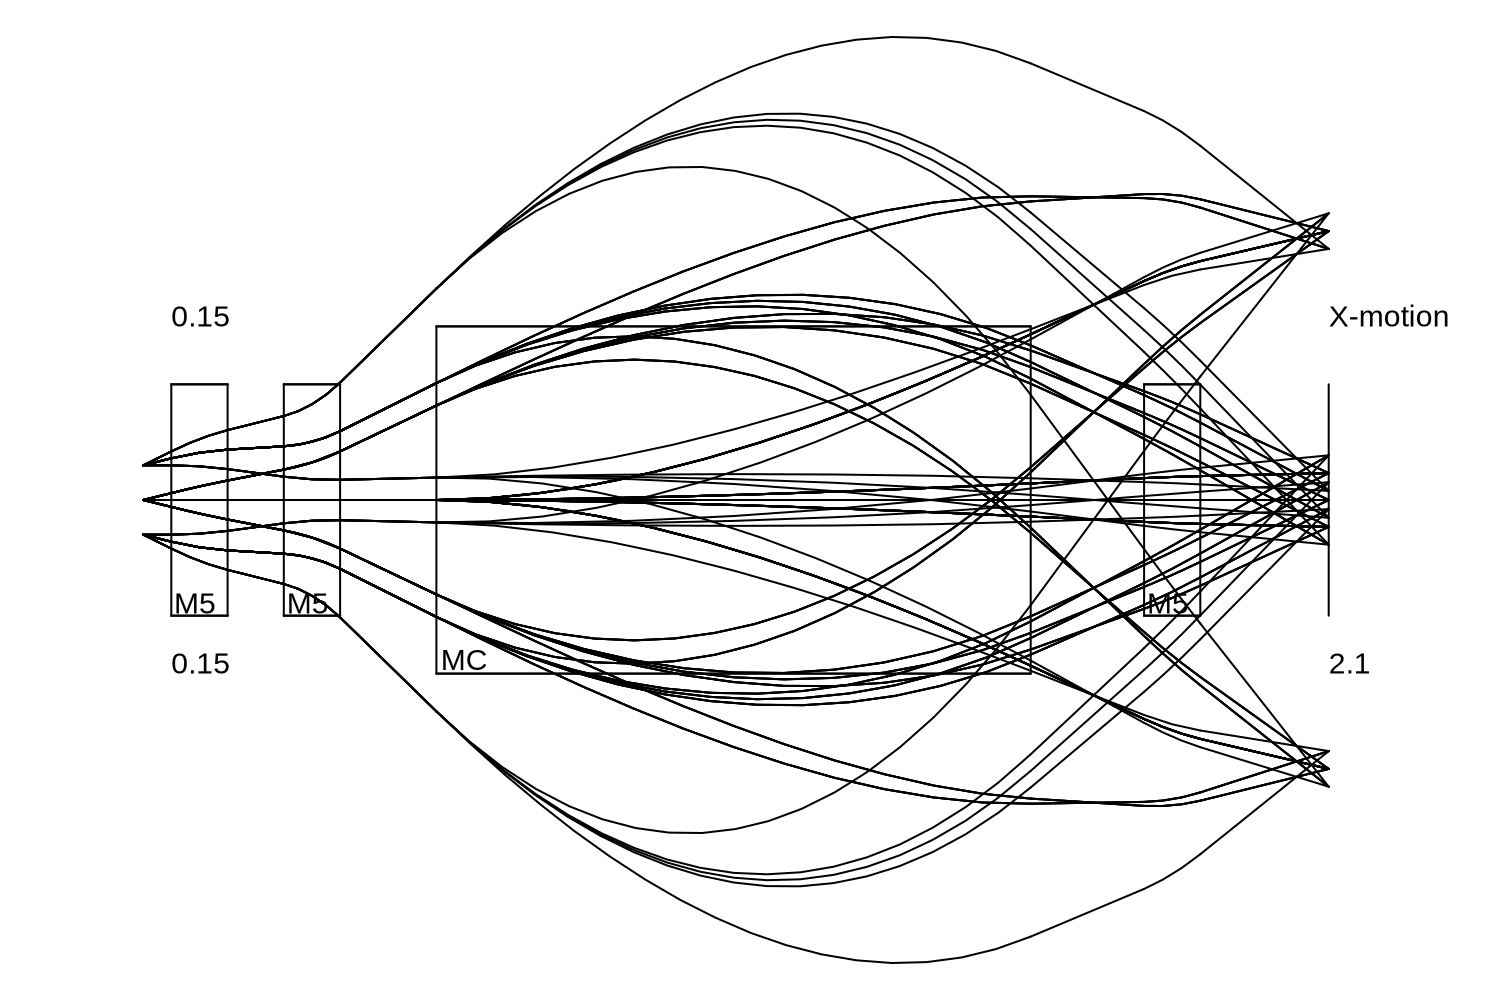

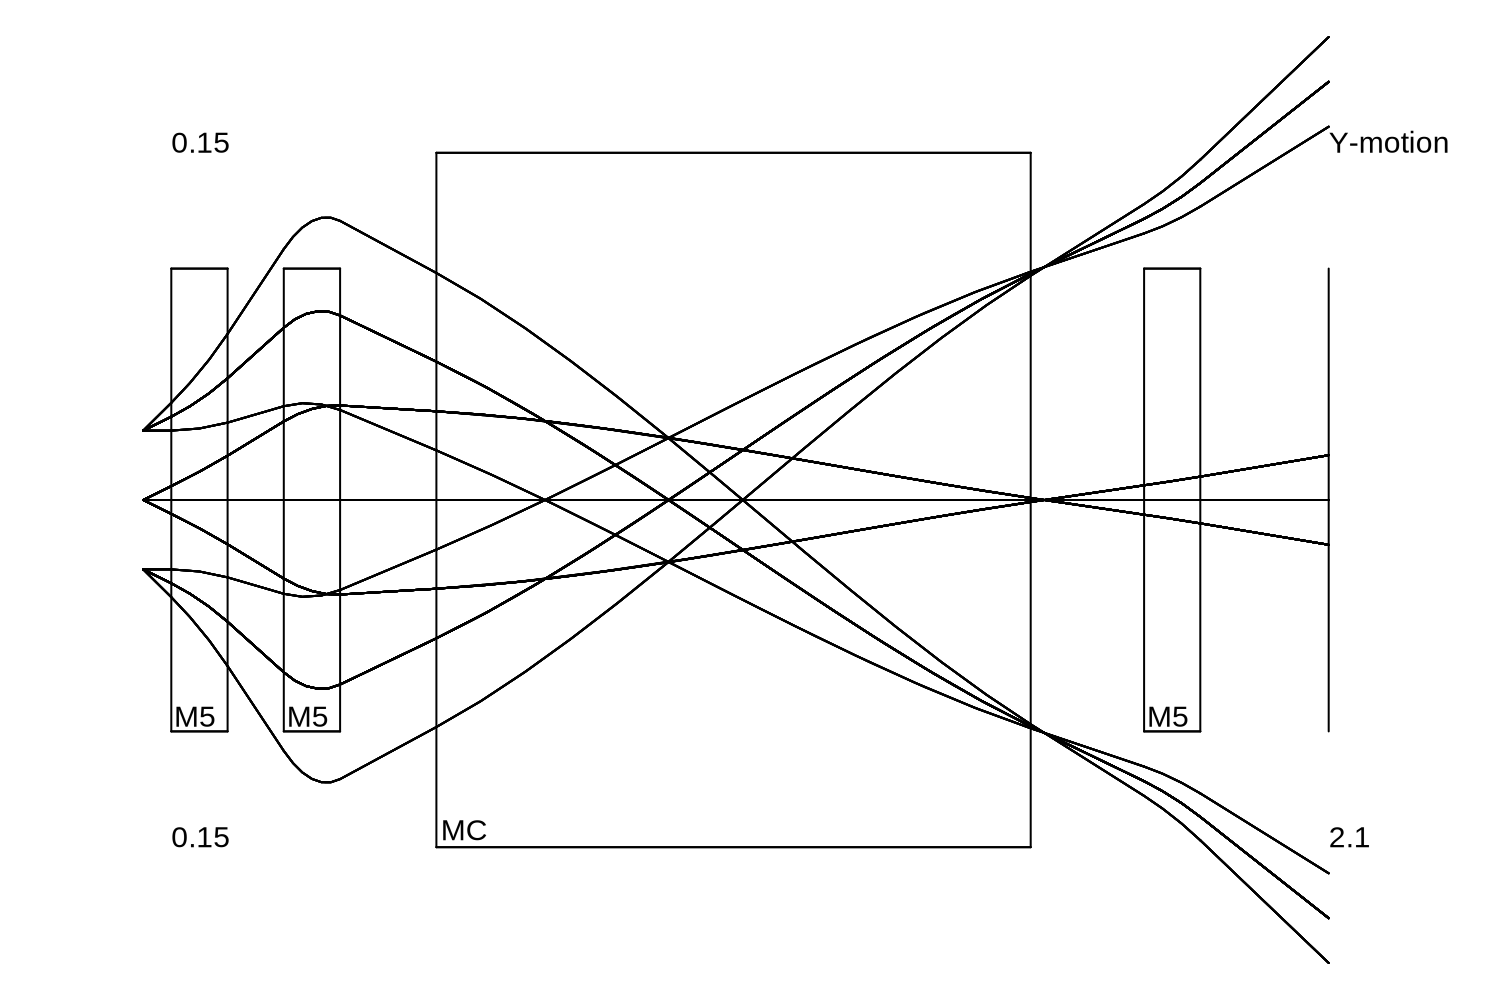

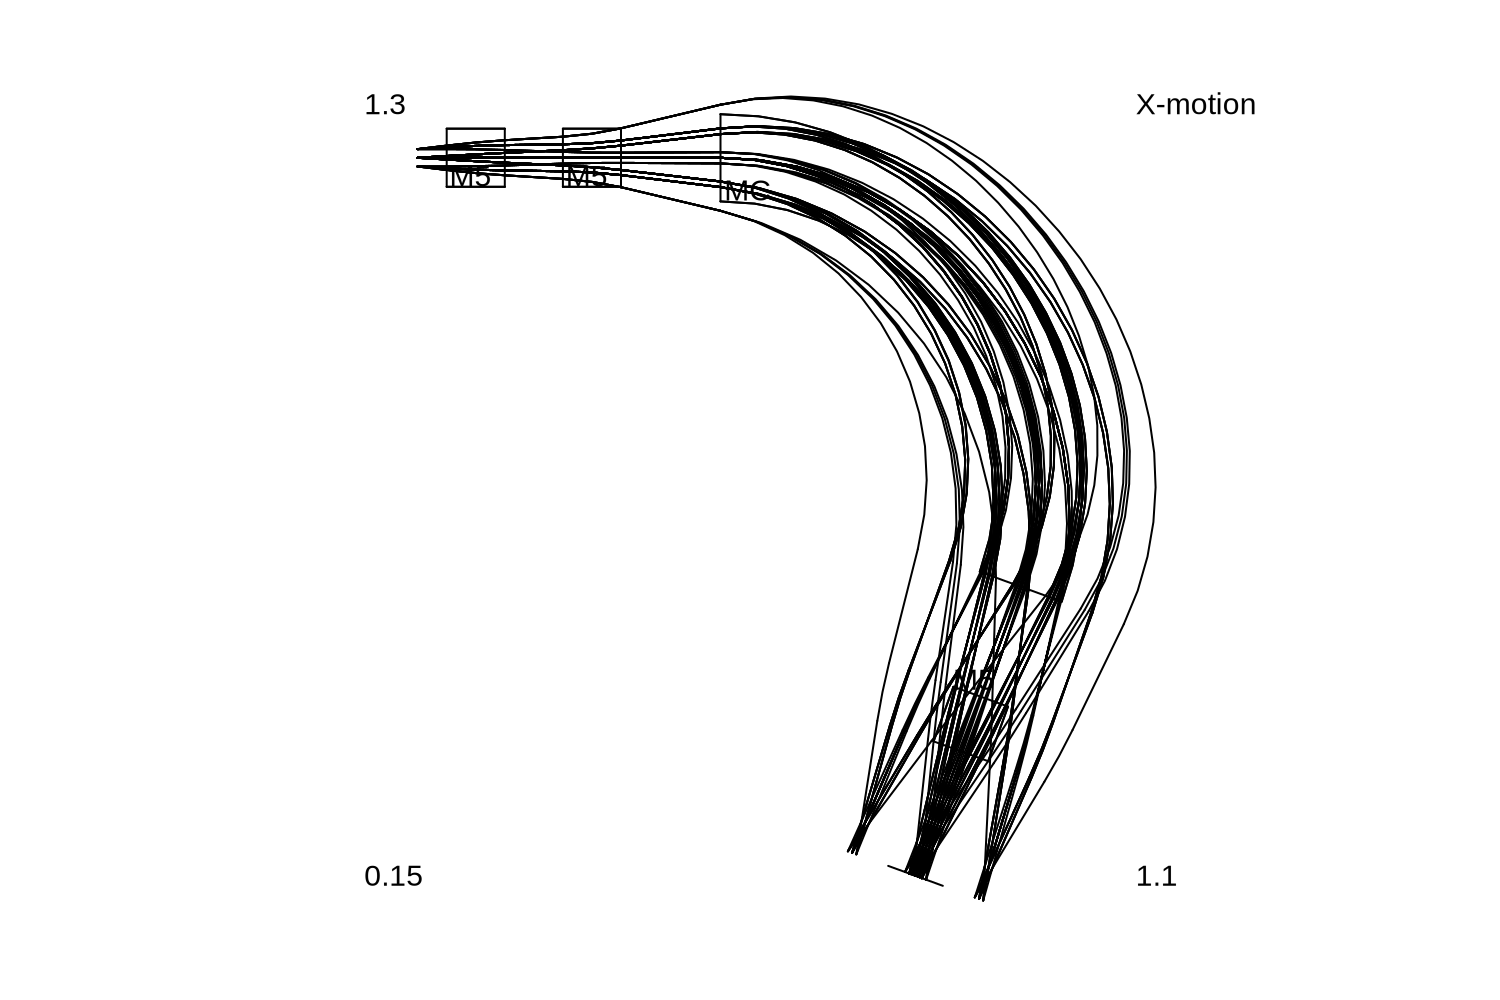

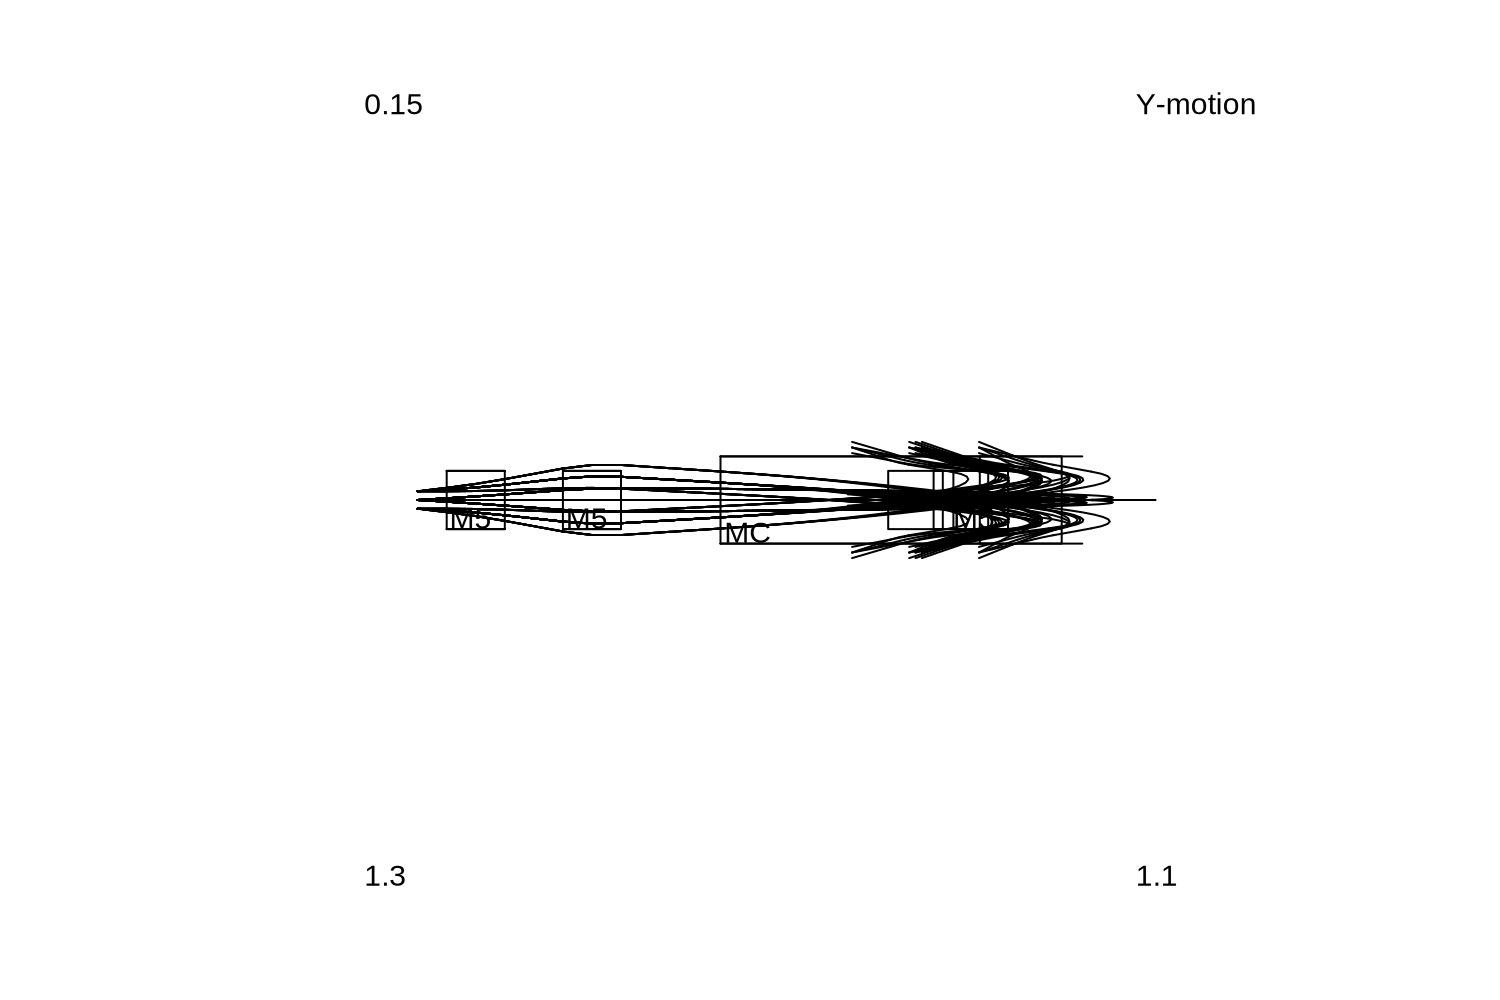

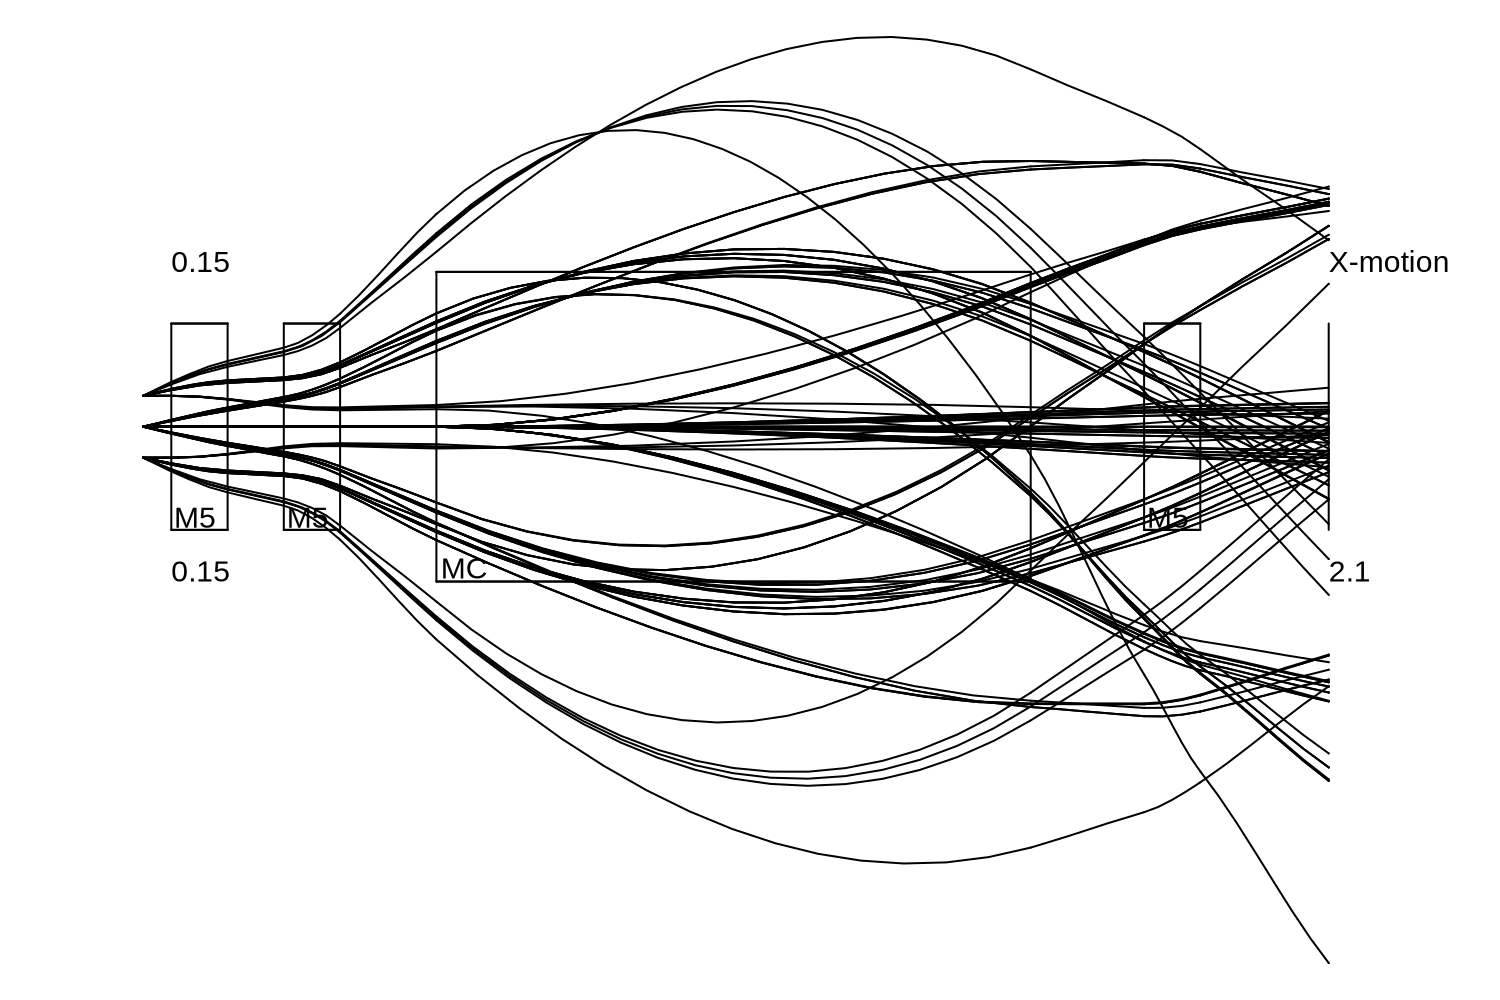

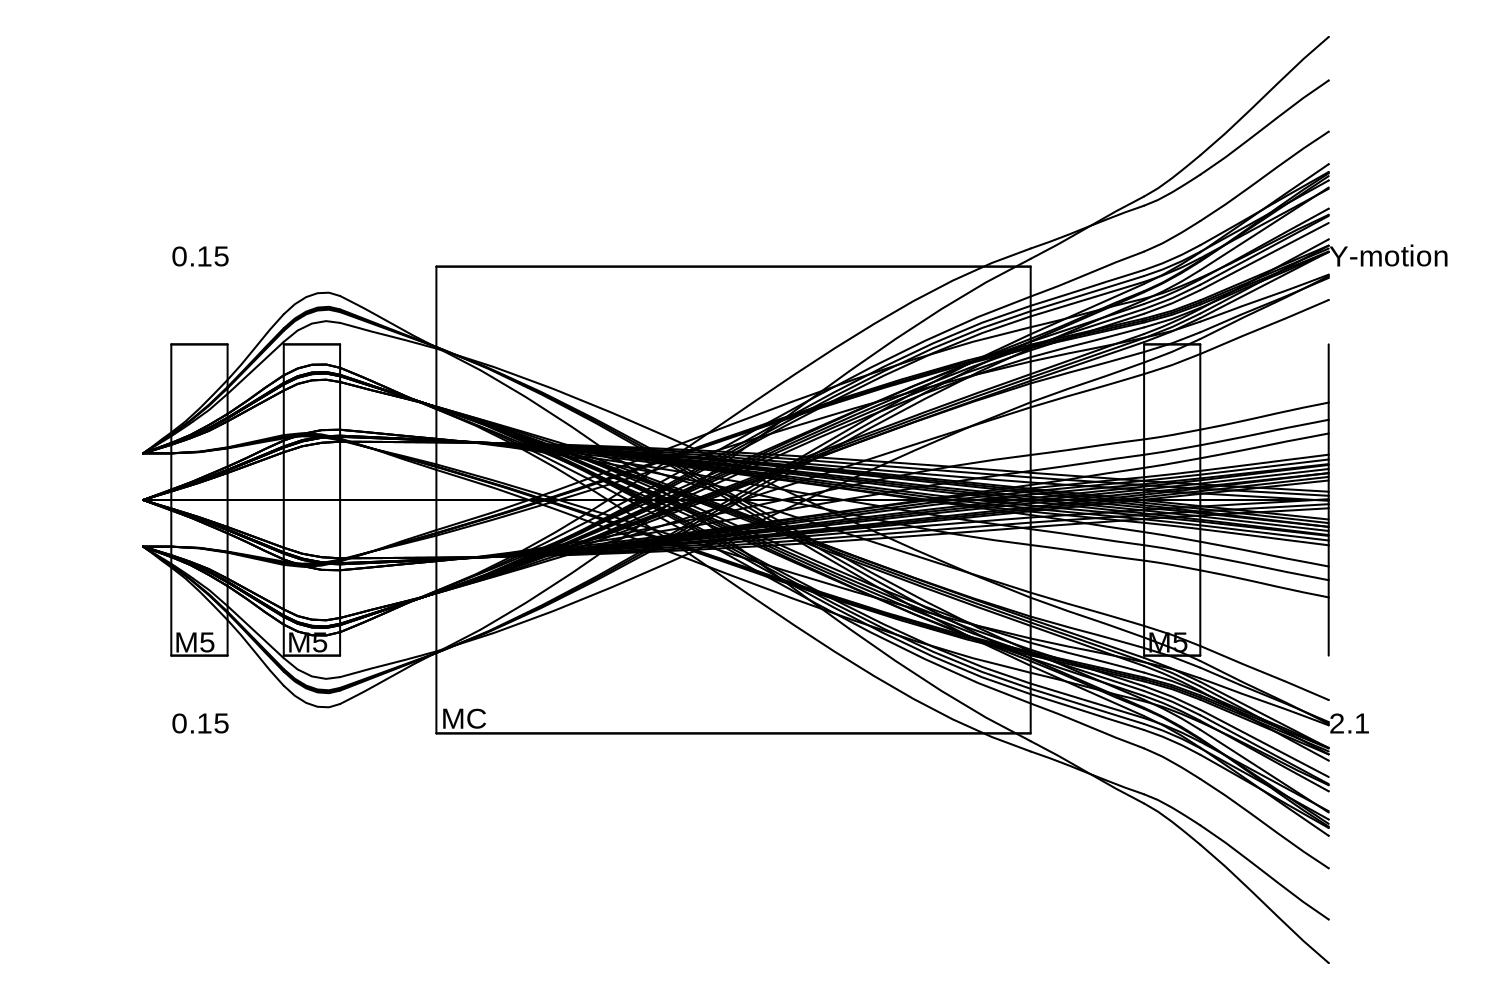

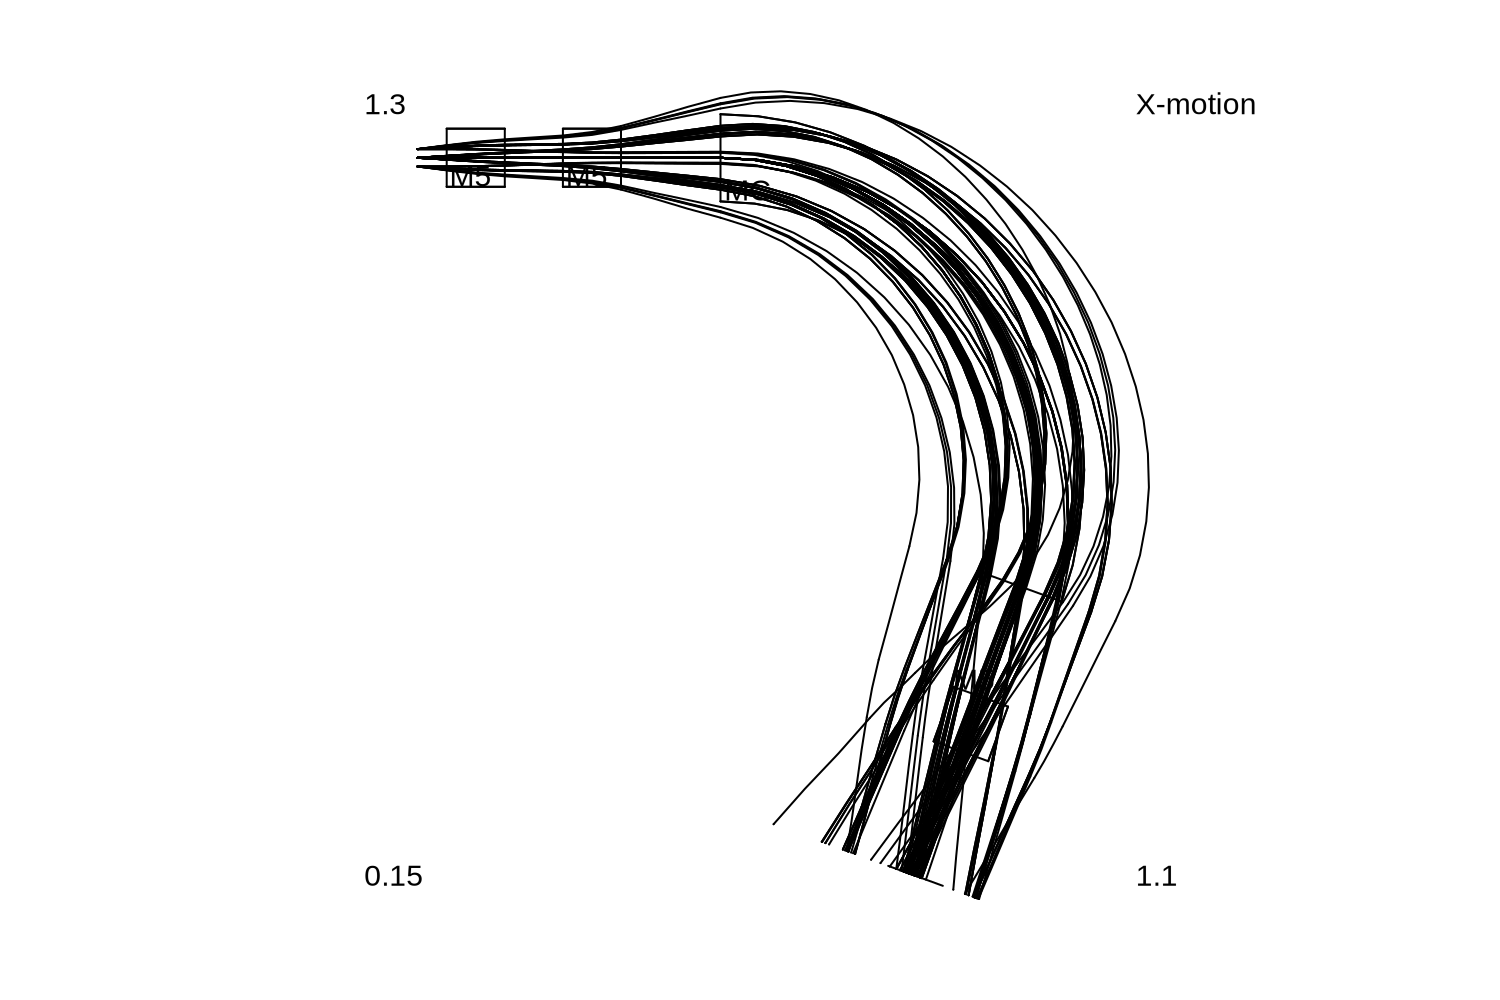

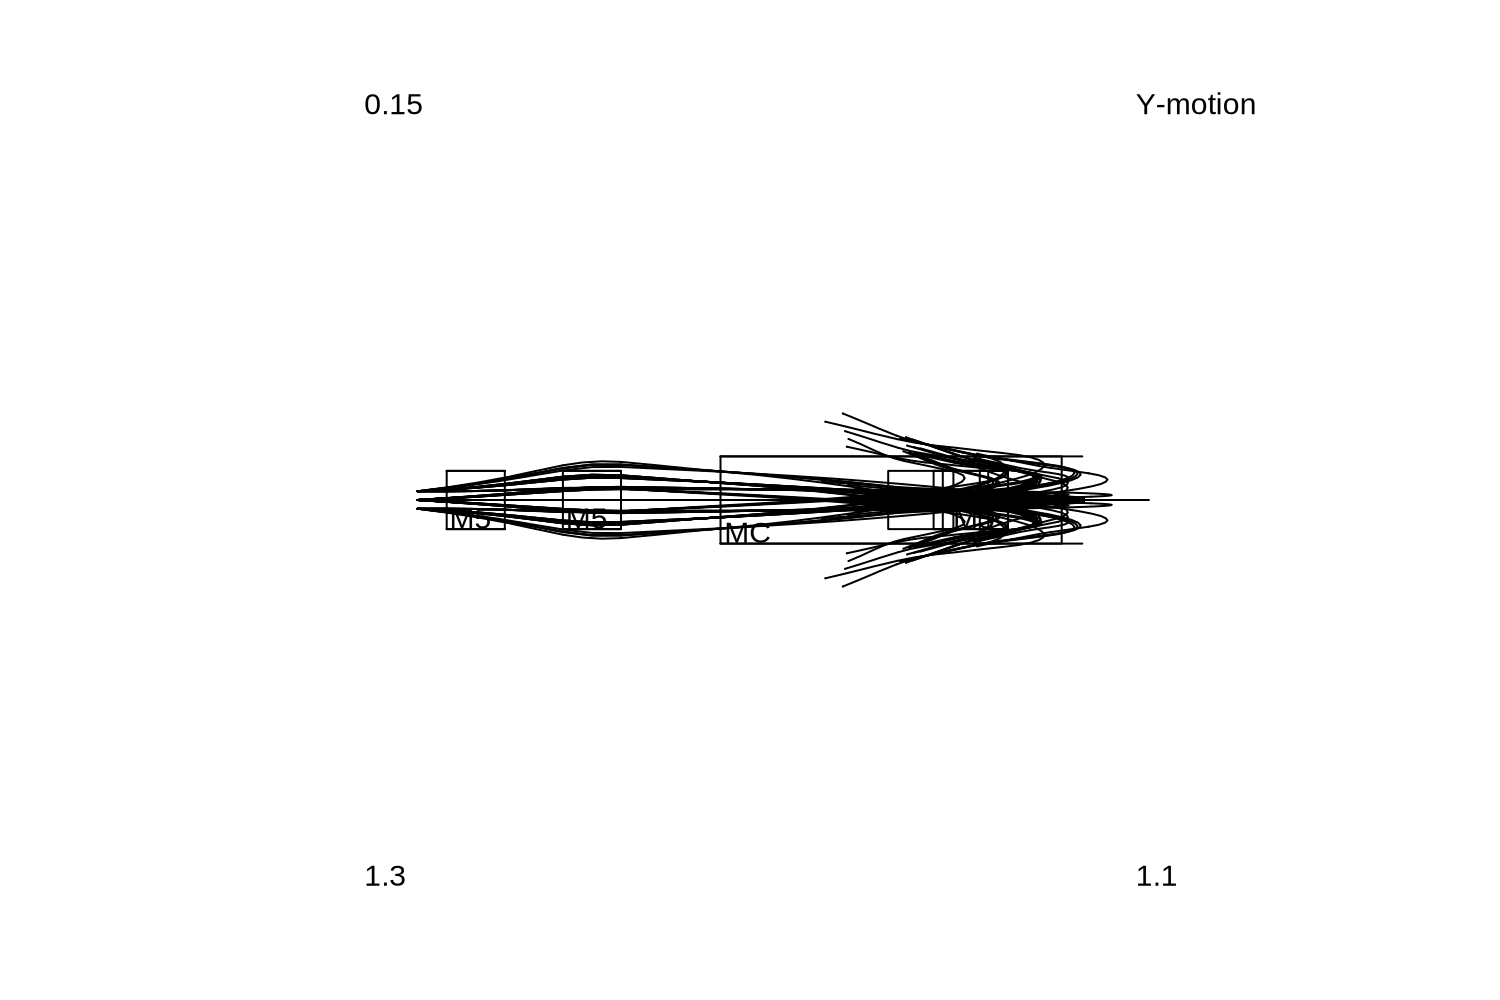

Resolution [order = 1]: 0.013227157401529155
Resolution [order = 5]: 0.061671302551472844


In [6]:
(sess
    .set_rays(gen_charictaristic_rays(R_FOIL, L_DRIFT, R_APERTURE, n=3), color=6)
    .add_rays(gen_charictaristic_rays(R_FOIL, L_DRIFT, R_APERTURE, n=3, energy=-0.1), color=8)
    .add_rays(gen_charictaristic_rays(R_FOIL, L_DRIFT, R_APERTURE, n=3, energy=0.1), color=7)
    .add_rays(gen_charictaristic_rays(R_FOIL, L_DRIFT, R_APERTURE, n=3, energy=-0.01), color=3)
    .add_rays(gen_charictaristic_rays(R_FOIL, L_DRIFT, R_APERTURE, n=3, energy=0.01), color=2)
)

for svg_data in sess.config_vis_lab_coordinates(False).config_order(1).exec_svg():
    display_svg(SVG(data=svg_data))
for svg_data in sess.config_vis_lab_coordinates(True).config_order(1).exec_svg():
    display_svg(SVG(data=svg_data))
for svg_data in sess.config_vis_lab_coordinates(False).config_order(5).exec_svg():
    display_svg(SVG(data=svg_data))
for svg_data in sess.config_vis_lab_coordinates(True).config_order(5).exec_svg():
    display_svg(SVG(data=svg_data))
    
(sess
    .set_rays(gen_charictaristic_rays(R_FOIL, L_DRIFT, R_APERTURE, n=3), color=6)
)

_, (
    V_magnification,
    V_focus,
    V_dispersion,
    V_magnification_y,
    V_focus_y,
    V_imagesize_x,
    V_imagesize_y,
), _, _ = sess.config_order(5).exec()
V_resolution_order_1 = np.abs(2 * R_APERTURE * V_magnification / V_dispersion)
V_resolution_order_5 = np.abs(2 * V_imagesize_x / V_dispersion)
print(f"Resolution [order = 1]: {V_resolution_order_1}")
print(f"Resolution [order = 5]: {V_resolution_order_5}")

Text(0.5, 1.0, 'Electron detection location by incident gamma ray energies.\ncompton only, $E_{gamma} = 16MeV(1+\\delta E)$ ')

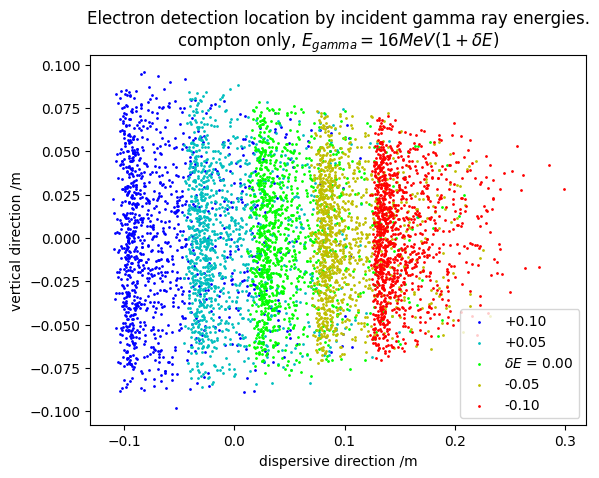

In [11]:
import matplotlib.pyplot as plt
from acceptance import rays_into_relative

e_center = 16*MeV

# _,_,ray_map,_ = sess.config_order(1).exec()
_,_,ray_map,_ = sess.config_order(5).exec()

def plot_monte_carlo(d_e:float, color):
    rays_in_raw = do_monte_carlo(e_center*(1+d_e),N_BY_Z*Z)
    rays_in = rays_into_relative(rays_in_raw,e_center)
    if NO_PAIR_PRODUCTION:
        rays_in = rays_in[rays_in_raw[5]==0]
    rays_out = []
    for x,a,y,b,e in rays_in:
        # (x,a,y,b,t,K) -> (x,a,y,b,t)
        x,a,y,b,_ = ray_map((x,a,y,b,0,e))
        rays_out.append((x,a,y,b,e))
    x,a,y,b,e = np.transpose(rays_out)
    plt.scatter(x,y,c=color, s=1)
    # plt.hist(x,bins=100,stacked=True)

NO_PAIR_PRODUCTION = True

N_BY_Z = 1_000_000
plot_monte_carlo(0.1,"b")
plot_monte_carlo(0.05,"c")
plot_monte_carlo(0,"lime")
plot_monte_carlo(-0.05,"y")
plot_monte_carlo(-0.1,"r")
plt.xlabel("dispersive direction /m")
plt.ylabel("vertical direction /m")
plt.legend([
    "+0.10",
    "+0.05",
    "$\delta E$ = 0.00",
    "-0.05",
    "-0.10",
])
plt.title("Electron detection location by incident gamma ray energies.\ncompton only, $E_{gamma} = 16MeV(1+\delta E)$ ")

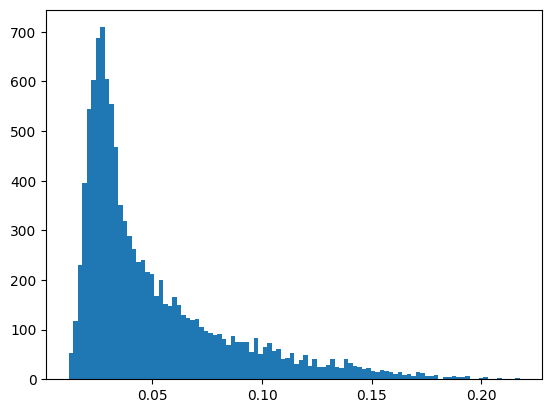

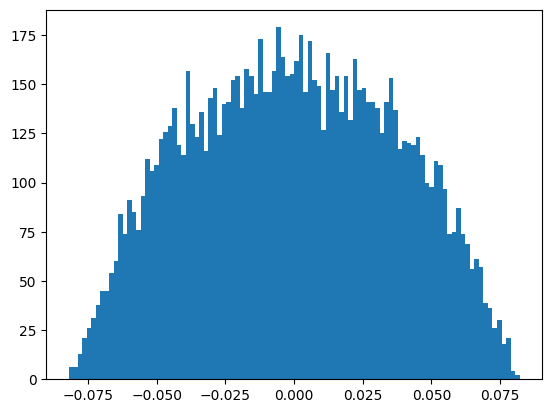

Text(0.5, 1.0, 'Electron detection location by incident gamma ray energies.\ncompton only, $E_{gamma} = 16MeV$ ')

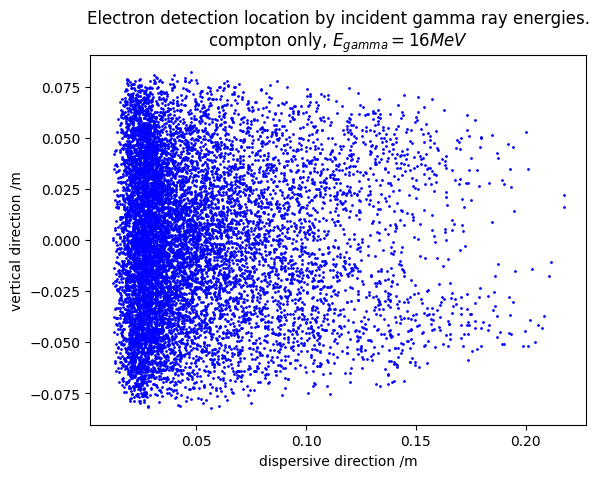

In [12]:
import matplotlib.pyplot as plt
from acceptance import rays_into_relative

e_center = 16*MeV

# _,_,ray_map,_ = sess.config_order(1).exec()
_,_,ray_map,_ = sess.config_order(5).exec()

def plot_monte_carlo(d_e:float, color):
    rays_in_raw = do_monte_carlo(e_center*(1+d_e),N_BY_Z*Z)
    rays_in = rays_into_relative(rays_in_raw,e_center)
    if NO_PAIR_PRODUCTION:
        rays_in = rays_in[rays_in_raw[5]==0]
    rays_out = []
    for x,a,y,b,e in rays_in:
        # (x,a,y,b,t,K) -> (x,a,y,b,t)
        x,a,y,b,_ = ray_map((x,a,y,b,0,e))
        rays_out.append((x,a,y,b,e))
    x,a,y,b,e = np.transpose(rays_out)
    plt.hist(x,bins=100)
    plt.show()
    plt.hist(y,bins=100)
    plt.show()
    plt.scatter(x,y,c=color, s=1)

NO_PAIR_PRODUCTION = True

N_BY_Z = 10_000_000
plot_monte_carlo(0,"blue")
plt.xlabel("dispersive direction /m")
plt.ylabel("vertical direction /m")
plt.title("Electron detection location by incident gamma ray energies.\ncompton only, $E_{gamma} = 16MeV$ ")

[15:31:38]  :  0.33%  3.5s/17.5min  ETA: 15:49:05 [T-17.5min]
[15:31:41]  :  0.67%  6.9s/17.4min  ETA: 15:48:56 [T-17.3min]
[15:31:44]  :  1.0%  10.1s/16.9min  ETA: 15:48:27 [T-16.7min]
[15:31:51]  :  1.67%  16.4s/16.4min  ETA: 15:47:59 [T-16.1min]
[15:31:57]  :  2.33%  22.9s/16.3min  ETA: 15:47:55 [T-16.0min]
[15:32:07]  :  3.33%  32.4s/16.2min  ETA: 15:47:46 [T-15.7min]
[15:32:19]  :  4.67%  44.6s/15.9min  ETA: 15:47:31 [T-15.2min]
[15:33:10]  :  5.33%  95.3s/29.8min  ETA: 16:01:21 [T-28.2min]
[15:33:36]  :  8.33%  2.0min/24.4min  ETA: 15:55:59 [T-22.4min]
[15:34:38]  :  10.33%  3.1min/29.6min  ETA: 16:01:13 [T-26.6min]
[15:36:05]  :  15.33%  4.5min/29.4min  ETA: 16:00:57 [T-24.9min]
[15:37:32]  :  20.33%  6.0min/29.3min  ETA: 16:00:52 [T-23.3min]
[15:40:27]  :  30.33%  8.9min/29.3min  ETA: 16:00:51 [T-20.4min]
[15:43:44]  :  42.33%  12.2min/28.7min  ETA: 16:00:18 [T-16.6min]
[15:48:39]  :  60.0%  17.1min/28.5min  ETA: 16:00:02 [T-11.4min]
[15:55:57]  :  83.33%  24.4min/29.2min  ETA:

Text(0, 0.5, 'image FWHM /cm [dispersive direction]')

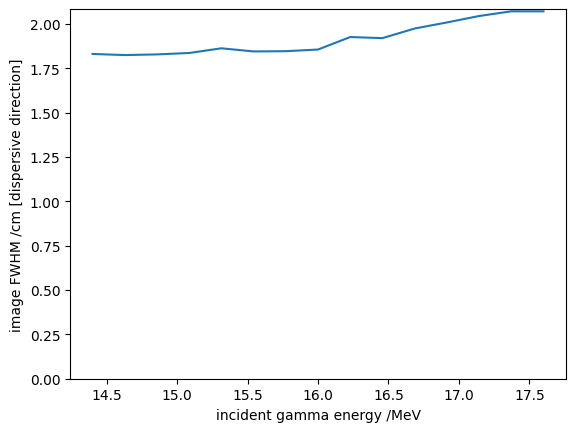

In [7]:
import matplotlib.pyplot as plt
from acceptance import rays_into_relative
from util import begin_timer

e_center = 16*MeV

_,_,ray_map,_ = sess.config_order(1).exec()
# _,_,ray_map,_ = sess.config_order(5).exec()

def fwhm_monte_carlo(d_e:float):
    rays_in_raw = do_monte_carlo(e_center*(1+d_e),N_BY_Z*Z)
    rays_in = rays_into_relative(rays_in_raw,e_center)
    if NO_PAIR_PRODUCTION:
        rays_in = rays_in[rays_in_raw[5]==0]
    rays_out = []
    for x,a,y,b,e in rays_in:
        # (x,a,y,b,t,K) -> (x,a,y,b,t)
        x,a,y,b,_ = ray_map((x,a,y,b,0,e))
        rays_out.append((x,a,y,b,e))
    x,a,y,b,e = np.transpose(rays_out)
    # x_sorted = np.sort(x)
    bins = np.linspace(np.min(x),np.max(x),50)
    bin_centers = (bins[1:]+bins[:-1])/2
    x_sorted = np.digitize(x, bins)
    xn = np.array([int(np.sum(x_sorted == i)) for i in range(1, len(bins))])
    xn = xn / np.max(xn)
    xmax = np.argmax(xn)
    x0 = np.interp(0.5,xn[:xmax+1],bin_centers[:xmax+1])
    x1 = np.interp(0.5,xn[xmax:][::-1],bin_centers[xmax:][::-1])
    # plt.plot(bin_centers,xn)
    # plt.scatter([x0,x1],np.interp([x0,x1],bin_centers,xn))
    # plt.show()
    return x1-x0
    # return x_sorted[x_sorted.size//4*3]-x_sorted[x_sorted.size//4]

NO_PAIR_PRODUCTION = True

N_BY_Z = 20_000_000
X = np.linspace(-0.1,0.1,15)
Y = X * 0
timer = begin_timer("")
for i in range(20):
    X_ = []
    for j in range(X.size):
        X_.append(fwhm_monte_carlo(X[j]))
        timer((i+(j+1)/X.size)/20)
    Y += np.array([fwhm_monte_carlo(x) for x in X])
Y /= 20
plt.plot(e_center/MeV*(1+X),Y/0.01)
plt.xlabel("incident gamma energy /MeV")
plt.ylim(bottom=0)
plt.ylabel("image FWHM /cm [dispersive direction]")
# plt.title("Electron detection location by incident gamma ray energies.\ncompton only, $E_{gamma} = 16MeV(1+\delta E)$ ")

Text(0.5, 1.0, 'Full-Width Half-Max of beam image vs incident gamma energy')

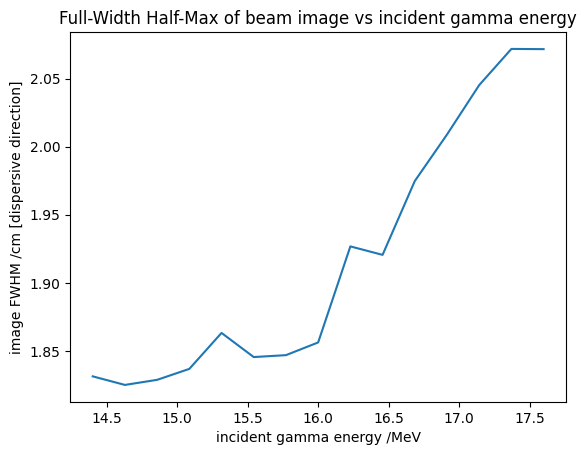

In [8]:
import scipy
plt.plot(e_center/MeV*(1+X),Y/0.01)
# plt.plot(e_center/MeV*(1+X),np.convolve(Y,np.ones(10)/10,mode="same")/0.01)
# plt.plot(np.convolve(e_center/MeV*(1+X),np.ones(3)/3,mode="valid"),np.convolve(Y,np.ones(3)/3,mode="valid")/0.01)
plt.xlabel("incident gamma energy /MeV")
plt.ylabel("image FWHM /cm [dispersive direction]")
plt.title("Full-Width Half-Max of beam image vs incident gamma energy")

In [128]:

N_BY_Z = 100_000_000
fwhm_monte_carlo(16*MeV)/V_dispersion

np.float64(0.01627532285684084)